In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

In [18]:
X_train = np.load("X_train_real.npy")
y_train = np.load("y_train_real.npy")

X_val = np.load("X_val_real.npy")
y_val = np.load("y_val_real.npy")

X_test = np.load("X_test_real.npy")
y_test = np.load("y_test_real.npy")

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

X_train_t.shape, y_train_t.shape


(torch.Size([2597, 20, 4]), torch.Size([2597]))

In [23]:
#fixing y_val NaN issue
valid_mask = ~torch.isnan(y_train_t)

X_train_t = X_train_t[valid_mask]
y_train_t = y_train_t[valid_mask]

print("New training set size:", X_train_t.shape)


New training set size: torch.Size([2596, 20, 4])


In [24]:
# building DataLoaders

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [25]:
print("y_val contains NaN:", torch.isnan(y_val_t).any().item())

y_val contains NaN: False


In [29]:
val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=64)

In [30]:
# Rebuilding CNN model

import torch.nn as nn
import torch.nn.functional as F

class CrisprCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.3)

        # dynamically compute fc1 input size
        with torch.no_grad():
            dummy = torch.zeros(1, 4, 20)
            x = F.relu(self.conv1(dummy))
            x = F.relu(self.conv2(x))
            x = F.max_pool1d(x, kernel_size=2)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()




In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrisprCNN().to(device)
model

CrisprCNN(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
num_epochs = 25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

Epoch 1/25 | Train Loss: nan | Val Loss: nan
Epoch 2/25 | Train Loss: nan | Val Loss: nan
Epoch 3/25 | Train Loss: nan | Val Loss: nan
Epoch 4/25 | Train Loss: nan | Val Loss: nan
Epoch 5/25 | Train Loss: nan | Val Loss: nan
Epoch 6/25 | Train Loss: nan | Val Loss: nan
Epoch 7/25 | Train Loss: nan | Val Loss: nan
Epoch 8/25 | Train Loss: nan | Val Loss: nan
Epoch 9/25 | Train Loss: nan | Val Loss: nan
Epoch 10/25 | Train Loss: nan | Val Loss: nan
Epoch 11/25 | Train Loss: nan | Val Loss: nan
Epoch 12/25 | Train Loss: nan | Val Loss: nan
Epoch 13/25 | Train Loss: nan | Val Loss: nan
Epoch 14/25 | Train Loss: nan | Val Loss: nan
Epoch 15/25 | Train Loss: nan | Val Loss: nan
Epoch 16/25 | Train Loss: nan | Val Loss: nan
Epoch 17/25 | Train Loss: nan | Val Loss: nan
Epoch 18/25 | Train Loss: nan | Val Loss: nan
Epoch 19/25 | Train Loss: nan | Val Loss: nan
Epoch 20/25 | Train Loss: nan | Val Loss: nan
Epoch 21/25 | Train Loss: nan | Val Loss: nan
Epoch 22/25 | Train Loss: nan | Val Loss: n

In [17]:
print("X_train contains NaN:", torch.isnan(X_train_t).any().item())
print("X_train contains Inf:", torch.isinf(X_train_t).any().item())

print("y_train contains NaN:", torch.isnan(y_train_t).any().item())
print("y_train contains Inf:", torch.isinf(y_train_t).any().item())

X_train contains NaN: False
X_train contains Inf: False
y_train contains NaN: True
y_train contains Inf: False


In [33]:
num_epochs = 25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)

        if torch.isnan(loss):
            print("NaN loss detected. Skipping batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")


Epoch 1/25 | Train Loss: 0.277692 | Val Loss: 0.094929
Epoch 2/25 | Train Loss: 0.090138 | Val Loss: 0.084824
Epoch 3/25 | Train Loss: 0.089477 | Val Loss: 0.084642
Epoch 4/25 | Train Loss: 0.088586 | Val Loss: 0.084496
Epoch 5/25 | Train Loss: 0.088636 | Val Loss: 0.084512
Epoch 6/25 | Train Loss: 0.087840 | Val Loss: 0.084224
Epoch 7/25 | Train Loss: 0.087035 | Val Loss: 0.084069
Epoch 8/25 | Train Loss: 0.086799 | Val Loss: 0.084291
Epoch 9/25 | Train Loss: 0.086969 | Val Loss: 0.083927
Epoch 10/25 | Train Loss: 0.086137 | Val Loss: 0.083736
Epoch 11/25 | Train Loss: 0.085681 | Val Loss: 0.083508
Epoch 12/25 | Train Loss: 0.086025 | Val Loss: 0.083676
Epoch 13/25 | Train Loss: 0.085710 | Val Loss: 0.083641
Epoch 14/25 | Train Loss: 0.085270 | Val Loss: 0.083252
Epoch 15/25 | Train Loss: 0.084538 | Val Loss: 0.083121
Epoch 16/25 | Train Loss: 0.085147 | Val Loss: 0.083003
Epoch 17/25 | Train Loss: 0.083857 | Val Loss: 0.083609
Epoch 18/25 | Train Loss: 0.084444 | Val Loss: 0.083010
E

In [34]:
import pandas as pd
import os

torch.save(model.state_dict(), "crispr_cnn_real_day9.pth")

loss_log = pd.DataFrame({
    "epoch": list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "val_loss": val_losses
})

loss_log.to_csv("loss_log_day9_real.csv", index=False)

print("model and real-data loss log saved.")

model and real-data loss log saved.


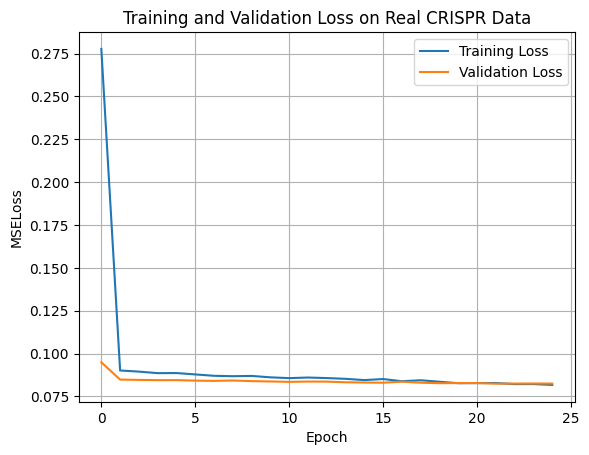

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSELoss")
plt.title("Training and Validation Loss on Real CRISPR Data")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_day9_real.png")
plt.show()